# Faster R-CNN on Coco
# 🚀 Faster R-CNN：目标检测的里程碑之作

Faster R-CNN 是目标检测领域里程碑式的工作，由 Shaoqing Ren、Kaiming He、Ross Girshick 和 Jian Sun 在 2015 年提出（论文标题：[*Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks*](https://arxiv.org/abs/1506.01497)）。它在 R-CNN 系列中承前启后，解决了此前方法的速度瓶颈，同时保持了高精度。

---

## 🌟 一、核心创新点

### 1. 引入 Region Proposal Network (RPN) —— 革命性的区域提议机制

- **取代 Selective Search**：在 Fast R-CNN 中，区域提议仍依赖外部算法（如 Selective Search），速度慢且与网络分离。
- **RPN 是全卷积网络**：与检测网络共享卷积特征图，直接在特征图上生成候选框（anchor-based），实现“端到端”训练。
- **多尺度 anchor 设计**：在每个位置预设多个尺度和长宽比的 anchor，有效应对不同大小目标。

### 2. 端到端联合训练

- RPN 和 Fast R-CNN 检测头共享卷积特征，通过交替训练或近似联合训练，实现整个网络的端到端优化。
- 这是首次将“区域提议 + 目标检测”统一到一个深度网络中，极大提升效率和一致性。

### 3. Anchor 机制的开创性应用

- Faster R-CNN 首次系统化使用 anchor boxes 作为候选框基础，这一思想深刻影响了后续几乎所有目标检测器（如 SSD、YOLOv2+、RetinaNet 等）。
- Anchor 机制让网络学习“相对偏移”，而非绝对坐标，提升泛化能力。

### 4. 计算效率大幅提升

- 相比 R-CNN（~50s/图）和 Fast R-CNN（~2s/图），Faster R-CNN 在 GPU 上可达 **5–10 FPS**（使用 VGG16），真正迈向“近实时”检测。
- 共享卷积特征避免重复计算，是效率飞跃的关键。

---

## 🌍 二、影响力与历史地位

### 1. 奠定 Two-Stage 检测器的主流架构

- 成为后续如 **Mask R-CNN**、**Cascade R-CNN**、**Libra R-CNN** 等高性能检测器的基础框架。
- “RPN + RoI Pooling + 分类/回归头” 成为标准范式。

### 2. 推动目标检测进入深度学习黄金时代

- 在 **PASCAL VOC**、**MS COCO** 等权威数据集上长期霸榜，证明深度学习在检测任务上的强大能力。
- 2015 年 COCO 检测冠军即基于 Faster R-CNN，引发学术界和工业界广泛关注。

### 3. 工业落地广泛

- 被广泛应用于 **自动驾驶**（如 Waymo）、**机器人视觉**、**安防监控**、**医疗影像**等领域。
- 成为许多商业检测系统的底层架构。

### 4. 启发 One-Stage 方法的发展

- 尽管是 Two-Stage 方法，但其 **anchor 机制** 被 SSD、YOLOv2 等 One-Stage 方法借鉴，推动整个领域演进。
- 后续很多改进（如 FPN、ATSS、IoU Loss）都建立在 Faster R-CNN 框架之上。

### 5. 学术引用与开源生态

- 截至 2024 年，论文引用量 **超 4 万次**（Google Scholar），是计算机视觉领域被引最高的论文之一。
- 官方代码和众多复现版本（如 **Detectron**、**mmdetection**）极大推动社区发展。

---

## ✅ 总结一句话

> **Faster R-CNN 通过引入 RPN 和 anchor 机制，首次实现端到端可训练的高效目标检测框架，不仅大幅提速，更奠定了现代目标检测的基础架构，是深度学习目标检测发展史上的分水岭之作。**

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from pathlib import Path

# 设置训练数据的路径
DATA_ROOT = Path("~/workspace/hands-dirty-on-dl/dataset").expanduser()
# 设置预训练模型参数路径
TORCH_HUB_PATH = Path("~/workspace/hands-dirty-on-dl/pretrained_models").expanduser()
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
from torchvision.datasets import wrap_dataset_for_transforms_v2
from hdd.scripts.detection.coco_utils import _coco_remove_images_without_annotations

COCO_ROOT = Path(DATA_ROOT).expanduser() / "coco"


def get_coco(train: bool, transforms=None):
    image_path = f"{COCO_ROOT}/train2017" if train else f"{COCO_ROOT}/val2017"
    annotation_file_path = (
        f"{COCO_ROOT}/annotations/instances_train2017.json"
        if train
        else f"{COCO_ROOT}/annotations/instances_val2017.json"
    )

    dataset = datasets.CocoDetection(
        root=image_path,
        annFile=annotation_file_path,
        transforms=transforms,
    )
    target_keys = ["boxes", "labels", "image_id"]
    dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=target_keys)

    if train:
        dataset = _coco_remove_images_without_annotations(dataset)
    return dataset


train_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.ConvertBoundingBoxFormat(tv_tensors.BoundingBoxFormat.XYXY),
        v2.SanitizeBoundingBoxes(),
        v2.ToPureTensor(),
    ]
)

val_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.ConvertBoundingBoxFormat(tv_tensors.BoundingBoxFormat.XYXY),
        v2.ToPureTensor(),
    ]
)

train_dataset = get_coco(train=True, transforms=train_transforms)
val_dataset = get_coco(train=False, transforms=val_transforms)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print("----------------------------------------------------")
img, target = val_dataset[0]
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")

loading annotations into memory...
Done (t=5.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
Train dataset size: 117266
Val dataset size: 5000
----------------------------------------------------
type(img) = <class 'torch.Tensor'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['image_id', 'boxes', 'labels'])
type(target['boxes']) = <class 'torch.Tensor'>
type(target['labels']) = <class 'torch.Tensor'>


In [3]:
from hdd.scripts.detection.group_by_aspect_ratio import (
    GroupedBatchSampler,
    create_aspect_ratio_groups,
)

train_batch_size = 16
train_sampler = torch.utils.data.RandomSampler(train_dataset)
group_ids = create_aspect_ratio_groups(train_dataset, k=3)
train_batch_sampler = GroupedBatchSampler(train_sampler, group_ids, train_batch_size)
val_sampler = torch.utils.data.SequentialSampler(val_transforms)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn=lambda batch: tuple(zip(*batch)),
    shuffle=True,
    num_workers=8,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_batch_size,
    collate_fn=lambda batch: tuple(zip(*batch)),
    num_workers=4,
)

Using [0, 0.5, 0.6299605249474366, 0.7937005259840997, 1.0, 1.2599210498948732, 1.5874010519681994, 2.0, inf] as bins for aspect ratio quantization
Count of instances per bin: [  104   982 24236  2332  8225 74466  5763  1158]


### Modifying the model to add a different backbone

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import MobileNet_V2_Weights
from torchvision.models.detection.backbone_utils import mobilenet_backbone

# load a pre-trained model for classification and return only the features
# mobilenet_backbone会将BN Layer冻结且可指定可训练的层数
backbone = mobilenet_backbone(
    backbone_name="mobilenet_v2", fpn=False, pretrained=True, trainable_layers=3
)

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"], output_size=7, sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
num_classes = 91
model = FasterRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)
model = model.to(DEVICE)

/home/tf/anaconda3/envs/pytorch-cu124/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tf/anaconda3/envs/pytorch-cu124/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from hdd.train.warmup_scheduler import GradualWarmupScheduler

weight_decay = 1e-4
# ！！！！！！！！！！！！！！！！！！！！！！！！！
# ！！！！！！！！！！！！！！！！！！！！！！！！！
# 调了好久的adamw结果发现learning rate太高了
# ！！！！！！！！！！！！！！！！！！！！！！！！！
# ！！！！！！！！！！！！！！！！！！！！！！！！！
learning_rate = 0.00001
max_iterations = 50_000
norm_params, other_params = torchvision.ops._utils.split_normalization_params(model)
# Do not apply weight decay to norm parameters
parameters = [
    {"params": norm_params, "weight_decay": 0},
    {"params": other_params, "weight_decay": weight_decay},
]
optimizer = torch.optim.AdamW(
    parameters, lr=learning_rate, betas=[0.9, 0.99], weight_decay=weight_decay
)
base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, max_iterations, eta_min=1e-6
)
scheduler = GradualWarmupScheduler(
    optimizer,
    multiplier=1.0,
    total_epoch=2000,
    after_scheduler=base_scheduler,
)

In [6]:
from hdd.scripts.detection import utils
import math
import sys


def train_one_epoch(
    model, optimizer, scheduler, data_loader, device, epoch, print_freq, scaler=None
) -> utils.MetricLogger:
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]
        with torch.amp.autocast(enabled=scaler is not None, device_type="cuda"):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [7]:
import time
from hdd.scripts.detection.coco_utils import get_coco_api_from_dataset
from hdd.scripts.detection.coco_eval import CocoEvaluator


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = ["bbox"]
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 1000, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"]: output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    print("Averaged stats:", metric_logger)

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

In [8]:
# 使用混合精度训练
scaler = torch.amp.GradScaler()
max_epochs = int(max_iterations / (len(train_dataset) / train_batch_size))
print(f"Max epochs: {max_epochs}")
for epoch in range(max_epochs):
    train_one_epoch(
        model, optimizer, scheduler, train_dataloader, DEVICE, epoch, 100, scaler
    )
    # evaluate after every epoch
    evaluate(model, val_dataloader, device=DEVICE)

Max epochs: 6
Epoch: [0]  [   0/7330]  eta: 3:28:01  lr: 0.000000  loss: 5.4267 (5.4267)  loss_classifier: 4.5129 (4.5129)  loss_box_reg: 0.0877 (0.0877)  loss_objectness: 0.6918 (0.6918)  loss_rpn_box_reg: 0.1343 (0.1343)  time: 1.7028  data: 0.4867  max mem: 4694
Epoch: [0]  [ 100/7330]  eta: 0:28:38  lr: 0.000001  loss: 5.2504 (5.3277)  loss_classifier: 4.3832 (4.4623)  loss_box_reg: 0.0605 (0.0537)  loss_objectness: 0.6908 (0.6915)  loss_rpn_box_reg: 0.1224 (0.1202)  time: 0.2223  data: 0.0059  max mem: 7728
Epoch: [0]  [ 200/7330]  eta: 0:27:27  lr: 0.000001  loss: 2.7674 (4.7979)  loss_classifier: 1.9156 (3.9324)  loss_box_reg: 0.0827 (0.0627)  loss_objectness: 0.6746 (0.6878)  loss_rpn_box_reg: 0.1076 (0.1149)  time: 0.2259  data: 0.0061  max mem: 7728
Epoch: [0]  [ 300/7330]  eta: 0:26:41  lr: 0.000002  loss: 1.2722 (3.6590)  loss_classifier: 0.4222 (2.7942)  loss_box_reg: 0.1153 (0.0773)  loss_objectness: 0.6192 (0.6727)  loss_rpn_box_reg: 0.1122 (0.1148)  time: 0.2177  data: 

# Run inference

/home/tf/anaconda3/envs/pytorch-cu124/lib/python3.11/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


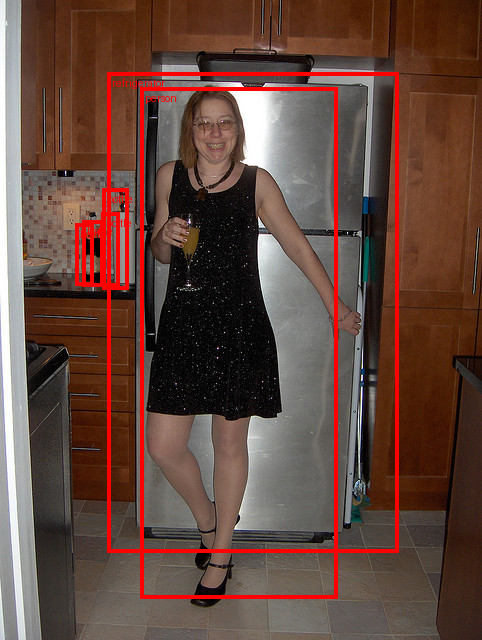

In [9]:
from torchvision.io.image import decode_image
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import (
    FasterRCNN_ResNet50_FPN_V2_Weights,
)
from torchvision.transforms.functional import to_pil_image

raw_img = decode_image("./resources/coco_test.jpg")

model.eval()

# Step 3: Apply inference preprocessing transforms
img = val_transforms(raw_img, None)
img = [img[0].to(DEVICE)]
# Step 4: Use the model and visualize the predictions
prediction = model(img)[0]

# get labels for each prediction
indices = torch.where(prediction["scores"] > 0.3)
labels = [
    FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT.meta["categories"][i]
    for i in prediction["labels"][indices]
]

box = draw_bounding_boxes(
    raw_img,
    boxes=prediction["boxes"][indices],
    labels=labels,
    colors="red",
    width=4,
    font_size=30,
)
to_pil_image(box.detach())